## Classification of Parkinson patients using an extra feature of Tapping: Std of the interval.

In [95]:
import synapseclient
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt

## Building data frame using tapping performance and demographic information

In [2]:
with open('MemoryTable.csv') as csvfile:
    MemTable=pd.read_csv(csvfile, delimiter=',')
with open('DemoTable.csv') as csvfile:
    DemoTable=pd.read_csv(csvfile, delimiter=',')    
    
MemTable.columns
MemTable=MemTable.drop(['ROW_ID', 'ROW_VERSION','recordId','createdOn','appVersion','phoneInfo','MemoryGameResults.json.startDate','MemoryGameResults.json.endDate','MemoryGameResults.json.MemoryGameGameRecords','medTimepoint'], axis=1)
MemTableN = MemTable.groupby("healthCode")["MemoryGameResults.json.MemoryGameOverallScore"].mean()
MemTableN = pd.DataFrame(MemTableN)  
MemTableN = MemTableN.reset_index()
print(MemTableN.head())


                             healthCode  \
0  00081bd9-9abd-4003-b035-de6cc3e8c922   
1  0085b356-0550-4cf1-85bd-2bcd89bf1201   
2  010aed99-c9b3-4bdc-a23b-530d619b43a9   
3  01185d64-7791-4282-8c3d-e657cd810bb0   
4  0142010e-cb15-4391-90b5-29ac0dbe5bae   

   MemoryGameResults.json.MemoryGameOverallScore  
0                                          210.0  
1                                          240.0  
2                                          255.0  
3                                          215.0  
4                                          257.5  


In [3]:
print(MemTableN.shape)

(968, 2)


In [4]:

#Sub-DataFrame of Demo Table with only features of interest: Age, diagnostic year, gender.
#DemoTable.head()
DemoTableN=DemoTable[["age","healthCode","diagnosis-year","gender"]]
DemoTableN.shape
#Merges TapTables with the PerfInfo and drops thos values in TapTable that are not defined in PerInfo
MemTableN=DemoTableN.merge(MemTableN)
MemTableN.shape
#TapMemTableN=pd.concat([TapTableN, MemTableN], axis=1)
#TapMemTableN
#TapMemTableN.head()
#TapTable.head()
#PatientTemp = TapTable.groupby("healthCode")["healthCode"].count()
#print(PatientTemp)
#TapMemTableN=TapMemTableN.merge(DemoTableN)
#TapMemTableN.head()


(911, 5)

In [5]:
MemTableN=MemTableN.dropna(subset=['age','gender','MemoryGameResults.json.MemoryGameOverallScore'])

In [6]:
# change gender column to categorical 0:female, 1: male
df_gender = pd.get_dummies(MemTableN['gender'],drop_first=True)
#print(TapTableN.gender.value_counts())
MemTableN = pd.concat([MemTableN, df_gender], axis=1)
MemTableN=MemTableN.drop(['healthCode','gender'], axis=1)



In [7]:
MemTableN.head()


,age,diagnosis-year,MemoryGameResults.json.MemoryGameOverallScore,Male
0,59.0,2014.0,304.000000,1
1,69.0,2010.0,217.272727,0
2,51.0,2014.0,280.000000,1
3,21.0,NaN,350.555556,1
4,23.0,NaN,285.000000,0


In [8]:
# diagnosis-year becomes years with diagnosed disease
MemTableN['diagnosis-year']=(2015-MemTableN['diagnosis-year'])
#NAN REPLACED WITH ZERO AND OTHER INT REPLACED WITH ONE
dfb = MemTableN['diagnosis-year'].notnull().astype(int)
MemTableN['YearsPD']=dfb
print(MemTableN)


      age  diagnosis-year  MemoryGameResults.json.MemoryGameOverallScore  \
0    59.0             1.0                                     304.000000   
1    69.0             5.0                                     217.272727   
2    51.0             1.0                                     280.000000   
3    21.0             NaN                                     350.555556   
4    23.0             NaN                                     285.000000   
..    ...             ...                                            ...   
906  61.0            12.0                                     247.500000   
907  53.0             NaN                                     270.000000   
908  22.0             NaN                                     325.000000   
909  73.0             NaN                                     225.000000   
910  20.0             NaN                                     325.000000   

     Male  YearsPD  
0       1        1  
1       0        1  
2       1        1  
3  

In [69]:
X=MemTableN[['age','Male','MemoryGameResults.json.MemoryGameOverallScore']]
y=MemTableN['YearsPD']


In [70]:
MemTableN['YearsPD'].unique()

array([1, 0])

In [71]:
MemTableN.isnull().values.any()

True

In [72]:
X.isnull().values.any()

False

In [73]:
y.isnull().values.any()

False

In [79]:
sum(y)

344

## Building the model

In [55]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [80]:
classifiers = [LogisticRegression(random_state=13), 
               GaussianNB(), 
               RandomForestClassifier(random_state=13)]


# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

In [81]:
result_table.isnull().values.any()

False

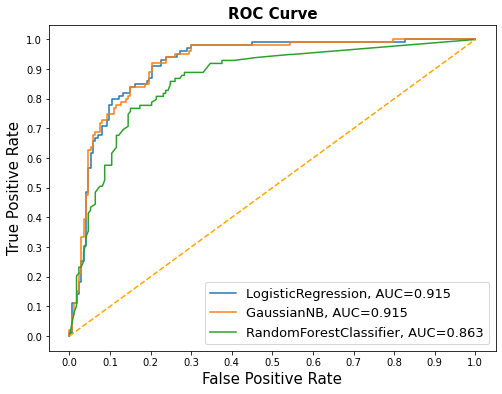

In [83]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [60]:
#Notes on the Report:
#Precision 0: TN/(TN+FN) of those predicted with out the disease, which how many really do not have it.
#Precision 1: TP/(TP+FP) of those predicted with the disease, which how many really had it.
#Recall 0: TN/(TN+FP) of those that dont have the disease how many were predicted with out the disease
#Recall 1: TP/(TP+FN) of those that have the disease how many were predicted with the disease
#Accuracy: TP+TN/(TP+TN+FP+FN), how many were classified correctly.
#For early diagnosis we would like to focus on recall 1 to be high. People with early stages of the disease should diagnose
#Few false negatives.

## Using AUC we select logistic regression to as the prefered model for evaluating memory skill


In [74]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train) 

    
    
 
    

LogisticRegression()

Accuracy of logistic regression classifier on test set: 0.86
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       173
           1       0.81      0.80      0.80        99

    accuracy                           0.86       272
   macro avg       0.85      0.84      0.84       272
weighted avg       0.86      0.86      0.86       272



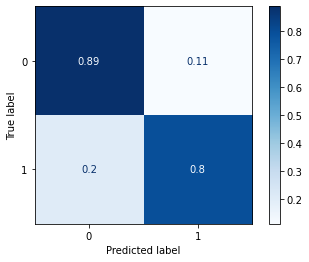

In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

y_pred = classifier.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))
confusionMatrix = confusion_matrix(y_test, y_pred, normalize='true')
print(classification_report(y_test, y_pred))
disp = plot_confusion_matrix(classifier, X_test, y_test,cmap=plt.cm.Blues,normalize='true')


In [88]:
## Prediction
y_pred=classifier.predict(X_test)
### Check Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_pred)

In [89]:
score

0.8566176470588235

In [92]:
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(classifier, pickle_out)
pickle_out.close()

In [94]:

#MemTableN = pd.DataFrame()  

a=classifier.predict([[56,1,5]])
a.dtype
a

array([1])

## Using only people before taking medication


In [16]:
#TapTableB = TapTableN[TapTableN['medTimepoint'] != "Just after Parkinson medication (at your best)"] 
#TapTableC = TapTableB[TapTableB['medTimepoint'] != "Another time"] 

#XX = TapTableC[['TapPerform','age','Male','Prefer not to answer']].to_numpy()
#YY=TapTableC['PDOn'].to_numpy()
#YY[YY!=0] = 1

#XX_train, XX_test, yy_train, yy_test = train_test_split(XX,YY , test_size=0.3, random_state=1)

##Training logistic regression
#logregC = LogisticRegression()
#logregC.fit(XX_train, yy_train)
#yy_predC = logregC.predict(XX_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregC.score(XX_test, yy_test)))
#confusionMatrixC = confusion_matrix(yy_test, yy_predC)
#print(confusionMatrixC)
#print(classification_report(yy_test, yy_predC))
#dispC = plot_confusion_matrix(logregC, XX_test, yy_test,cmap=plt.cm.Blues)



In [17]:
##Plotting ROC Curve

##Calculate probabilities. Notice that this is different than evaluating the predict y_pred
#y_probC = logregC.predict_proba(XX_test)
#y_prob1C = y_probC[:, 1]

#fprC, tprC, thresholdC = metrics.roc_curve(yy_test, y_prob1C)
#roc_aucC = metrics.auc(fprC, tprC)

#plt.title('Receiver Operating Characteristic')
#plt.plot(fprC, tprC, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()
##Saving this for using the new threshold
##y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3
##print(fprC)
##print(fpr)

## Graph to see time dependency

In [18]:
#Prob = logreg.predict_proba(X)
#ProbOfPD=Prob[:, 1]
#Ind=(TapTableN["diagnosis-year"]!=0)
#YearsPD=TapTableN["diagnosis-year"]
#nd=(YearsPD!=0)
#YearsPD[Ind]=(2015-YearsPD[Ind])
#plt.scatter(YearsPD, ProbOfPD, c="g", alpha=0.5, marker=r'$\clubsuit$',
#            label="Luck")
#plt.xlim([-0.5, 20])
#print(ProbOfPD[42])
#print(YearsPD[42])
##TapTableN["TimeDis"][Ind]=(2015-TapTableN["diagnosis-year"][Ind])
##print(TapTableN["age"][72])

## Classifying using diagnostic year as starting point of the disease

In [19]:
#Let us look at a histogram of the diagnosis year and find quantiles


#Bol=TapTableN["diagnosis-year"]!=0 
#Diagnosis=TapTableN["diagnosis-year"][Bol]
#Bol2=Diagnosis>1960
#Diagnosis= 2015-Diagnosis[Bol2]
#print(Diagnosis)
##hist = Diagnosis.hist(bins=10)
#YearsDiaQuant=Diagnosis.quantile([.25, .5, 0.75])

##Drop values were diagnosis year does not make sense
#Diagnosis = Diagnosis[Diagnosis > 15]
#print(Diagnosis)




## Classifier for first quantile

In [20]:
s1 = pd.Series([1, 1,2], index=['A', 'B','C'], name='s1')
s2 = pd.Series([3, 4], index=['A', 'B'], name='s2')

Temp=pd.concat([s1, s2], axis=1)

In [21]:
print(Temp)

   s1   s2
A   1  3.0
B   1  4.0
C   2  NaN


In [22]:
Temp.std()

s1    0.577350
s2    0.707107
dtype: float64